In [52]:
from glob import glob
import json
import os
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [53]:
sys.path.append(r'C:\Users\lesliec\code')

In [54]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [55]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_stim_events, find_nearest_ind
from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [56]:
%matplotlib notebook

#### Plot electrodes

### Load experiment

In [57]:
recfolder = r'F:\psi_exp\mouse669117\pilot_aw_2023-03-29_11-09-15\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [58]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

pilot_aw


### Load EEG data

In [59]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [60]:
print(eeg_ts[0])
print(eeg_ts[-1])

74.48285765775773
9075.33782511148


In [61]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

### Load SWDs

In [11]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')

Whoope there it is


In [12]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,62.907683,65.411671,2.503988,19,"[62.90768339318237, 63.042882738287446, 63.158..."
1,66.102868,68.190058,2.087190,16,"[66.1028679159616, 66.20286743157186, 66.30486..."
2,73.099234,74.083229,0.983995,9,"[73.09923402611828, 73.21323347391399, 73.3440..."
3,78.675207,81.261194,2.585987,17,"[78.67520701654675, 78.80320639652788, 78.9444..."
4,83.168785,84.357979,1.189194,10,"[83.16878525000968, 83.2935846454913, 83.42478..."


Print some stats

In [13]:
print('Number of SWDs in {:d} min recording: {:d} events'.format(int((eeg_ts[-1]-eeg_ts[0])/60), len(autoSWD_df)))
print('Average SWD duration: {:.1f} s [min={:.1f}, max={:.1f}]'.format(
    np.mean(autoSWD_df['duration'].values), np.min(autoSWD_df['duration'].values), np.max(autoSWD_df['duration'].values)))
print('Total time spent in SWD: {:.1f} min'.format(np.sum(autoSWD_df['duration'].values)/60))

Number of SWDs in 73 min recording: 829 events
Average SWD duration: 2.8 s [min=0.5, max=11.5]
Total time spent in SWD: 39.3 min


### Load units and spikes

In [62]:
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B3,probeB,1,3700,0.357119,VAL,268,173,186,SM-TH
1,B4,probeB,1,3700,0.357119,VAL,268,173,186,SM-TH
2,B7,probeB,2,3680,0.480737,VAL,268,173,186,SM-TH
3,B10,probeB,2,3680,0.480737,VAL,268,173,186,SM-TH
4,B11,probeB,3,3680,0.315913,VAL,268,172,186,SM-TH


In [63]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

ACA: 11 units
HIP: 154 units
ILA: 116 units
MO: 77 units
OLF: 147 units
PL: 175 units
RHP: 73 units
RSP: 104 units
RT-TH: 7 units
SM-TH: 227 units
SS: 30 units
VIS: 97 units
other-TH: 227 units


### Plot an SWD event

In [64]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'HIP', 'VIS', 'ACA', 'SS', 'MO']

In [31]:
SWDind = 1
SWDevent = autoSWD_df.iloc[SWDind]
print(SWDevent.duration)

2.0871898898174805


In [65]:
deltat = 0.5 # time around SWD to plot, s

Plot EEG

Plot EEG + all region raster

<IPython.core.display.Javascript object>


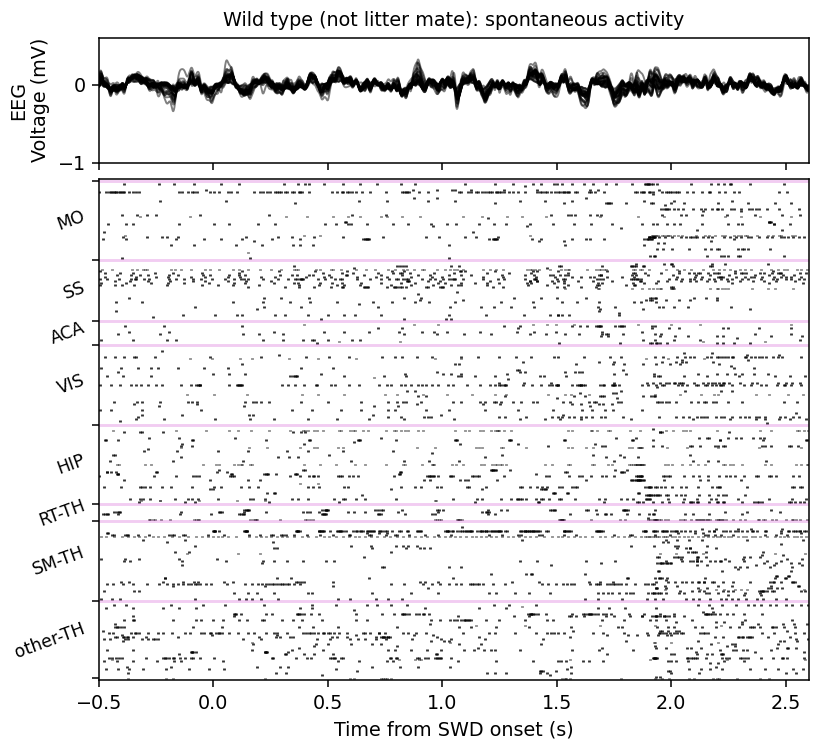

In [72]:
## Plot one half-slide ##
# timezero = SWDevent.onset
# pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
timezero = 100.0
pwin = np.array([100.0 - deltat, 102.1 + deltat])
umax = 40

fig = plt.figure(figsize=(6, 5.5)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.12, right=0.98, top=0.95, bottom=0.1, hspace=0.05, height_ratios=[1,4])
EEGax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1])

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > pwin[0]) & (eeg_ts < pwin[1]))[0]
# EEGax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
EEGax.plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
EEGax.set_xlim(pwin - timezero)
EEGax.set_xticklabels([])
EEGax.set_ylim([-1, 0.6])
EEGax.set_ylabel('EEG\nVoltage (mV)')
EEGax.set_title('Wild type (not litter mate): spontaneous activity') # 'GAT1-KO: SWD'
    
## Plot raster ##
# rasterax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwin[0]) & (uspiketimes < pwin[1]))[0]
        ]
        rasterax.eventplot(SWDspikes - timezero, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(-0.55, last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwin - timezero)
rasterax.set_xlabel('Time from SWD onset (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
# fig_name = 'SWD_EEG_NPX_example{:d}.png'.format(SWDind)
fig_name = 'spont_EEG_NPX_example.png'
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Plot ALL region raster

### Plot multiple SWD events

In [22]:
len(autoSWD_df)

829

In [25]:
autoSWD_df[(autoSWD_df['duration'] > 1.8) & (autoSWD_df['duration'] < 2.2)][:10]

,onset,offset,duration,spike_count,SWD_spike_times
1,66.102868,68.190058,2.087190,16,"[66.1028679159616, 66.20286743157186, 66.30486..."
21,196.202070,198.354060,2.151990,13,"[196.20206980036556, 196.33886915980443, 196.4..."
34,251.572628,253.498624,1.925996,14,"[251.57262780484655, 251.9530270677896, 252.10..."
35,254.475422,256.303019,1.827596,13,"[254.4754221804278, 254.61662190684095, 254.75..."
45,300.105219,302.073239,1.968020,13,"[300.1052188619777, 300.2220200312601, 300.348..."
47,306.862087,308.998882,2.136796,13,"[306.86208650416586, 307.0236881219402, 307.20..."
105,635.813841,637.819856,2.006015,14,"[635.8138406935439, 635.9538417334074, 636.243..."
130,745.071978,747.047959,1.975981,14,"[745.0719779810114, 745.2023767176904, 745.333..."
133,754.566686,756.618666,2.051980,13,"[754.5666859949622, 754.6914847858942, 754.993..."
134,758.479048,760.335030,1.855982,15,"[758.4790480914552, 758.5934469831428, 758.733..."


In [28]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'SS']
deltat = 0.5 # time around SWD to plot, s
SWDinds = [1, 34, 35, 45, 47]

<IPython.core.display.Javascript object>


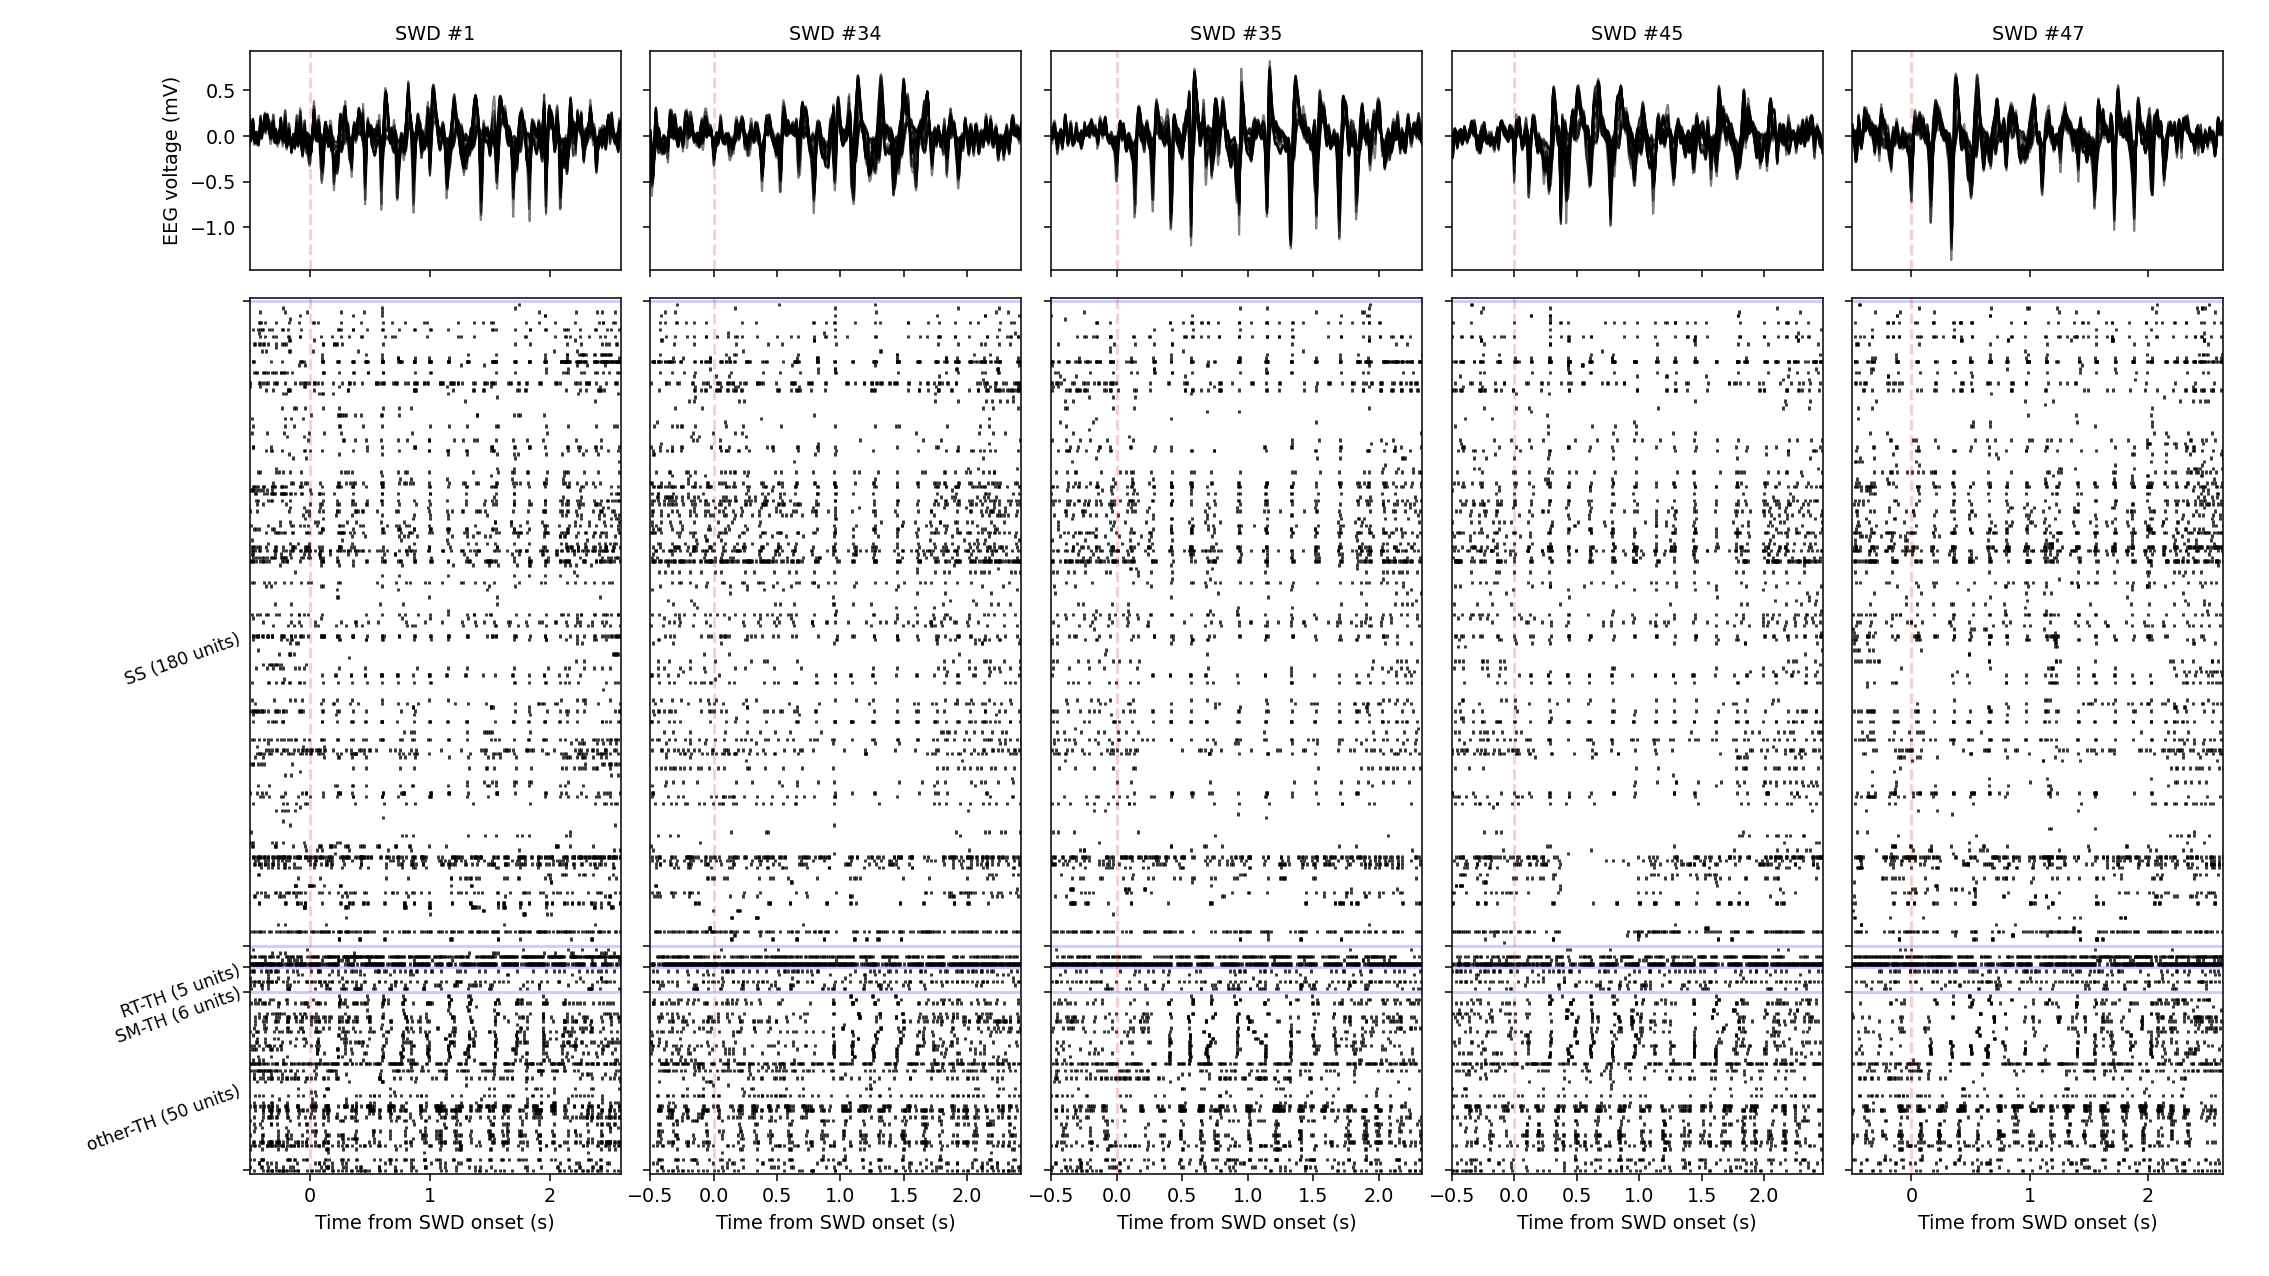

In [29]:
fig = plt.figure(figsize=(12, 6.75)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.11, right=0.98, top=0.96, bottom=0.08, hspace=0.05, height_ratios=[1,4])
EEGaxs = gs[0].subgridspec(ncols=len(SWDinds), nrows=1, wspace=0.08).subplots(sharey=True)
rasteraxs = gs[1].subgridspec(ncols=len(SWDinds), nrows=1, wspace=0.08).subplots(sharey=True)

for coli, SWDind in enumerate(SWDinds):
    SWDevent = autoSWD_df.iloc[SWDind]
    timezero = SWDevent.onset
    plotwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
    
    ## Plot EEG ##
    eeginds = np.nonzero((eeg_ts > plotwin[0]) & (eeg_ts < plotwin[1]))[0]
    EEGaxs[coli].axvline(0, color='r', linestyle='dashed', alpha=0.2)
    EEGaxs[coli].plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
    EEGaxs[coli].set_xlim(plotwin - timezero)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_title('SWD #{:d}'.format(SWDind))
    
    ## Plot raster ##
    rasteraxs[coli].axvline(0, color='r', linestyle='dashed', alpha=0.2)
    last_ind = 0
    regb = [last_ind]
    for ii, pregi in enumerate(plot_regions):
        regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
        for indi, urow in regdf.iterrows():
            uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
            SWDspikes = uspiketimes[
                np.nonzero((uspiketimes > plotwin[0]) & (uspiketimes < plotwin[1]))[0]
            ]
            rasteraxs[coli].eventplot(SWDspikes - timezero, lineoffsets=indi + last_ind, linelengths=1.0, color='black', alpha=0.8)
        if coli == 0:
            rasteraxs[coli].annotate(
                '{} ({:d} units)'.format(pregi, len(regdf)), xy=(-0.55, last_ind + indi/2 - 10), xycoords='data',
                annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
            )
        last_ind += indi + 2
        regb.append(last_ind - 1)
        rasteraxs[coli].axhline(last_ind - 1, color='b', alpha=0.2)

    rasteraxs[coli].set_ylim(-1, last_ind)
    rasteraxs[coli].set_xlim(plotwin - timezero)
    rasteraxs[coli].set_xlabel('Time from SWD onset (s)')
    rasteraxs[coli].set_yticks(regb)
    rasteraxs[coli].set_yticklabels([])

EEGaxs[0].set_ylabel('EEG voltage (mV)')

### SAVE ###
fig_name = 'multiSWD_EEG_NPX_example.png'
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Spatial interpolation

In [33]:
autoSWD_df[220:240]

,onset,offset,duration,spike_count,SWD_spike_times
220,874.440449,876.029239,1.588790,12,"[874.4404485660772, 874.5728477537233, 874.722..."
221,880.130014,880.932809,0.802795,5,"[880.1300136569488, 880.3104125500859, 880.439..."
222,885.378781,886.407575,1.028794,8,"[885.3787814523942, 885.3895813861296, 885.407..."
223,887.999565,889.590356,1.590790,9,"[887.9995653722051, 888.1767642849762, 888.326..."
224,891.553944,892.703537,1.149593,5,"[891.5539435638168, 891.8687416323288, 892.081..."
225,893.779130,894.327927,0.548797,4,"[893.7791299108724, 893.8059297464381, 894.167..."
226,895.212721,896.226315,1.013594,7,"[895.2127211148714, 895.3483202828836, 895.515..."
227,897.121909,898.773099,1.651190,11,"[897.1219094007777, 897.2351087062274, 897.506..."
228,901.661481,902.474276,0.812795,5,"[901.6614811027295, 901.8994795655993, 902.041..."
229,907.436244,908.194639,0.758395,3,"[907.4362438060116, 907.8042414292727, 908.194..."


In [58]:
## Create the EEG mesh ##
ml = np.linspace(-5, 5, 100)
ap = np.linspace(-5, 3, 100)
ML, AP = np.meshgrid(ml, ap)

In [59]:
SWDind = 220
deltat = 0.5
SWDevent = autoSWD_df.iloc[SWDind]
plot_window = [SWDevent.onset - deltat, SWDevent.offset + deltat]

plot_inds = np.nonzero((eeg_ts > plot_window[0]) & (eeg_ts < plot_window[1]))[0]
frameinds = plot_inds[::20]

ctx_EEG_timeseries = []
for indi in frameinds:
    ctx_EEG_timeseries.append(interpolate.griddata(
        (EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS]),
        filt_data[indi, :], (ML, AP), method='cubic',
    ))
spatiotempEEG = np.array(ctx_EEG_timeseries)

In [60]:
spatiotempEEG.shape

(324, 100, 100)

Plot and animate

<IPython.core.display.Javascript object>


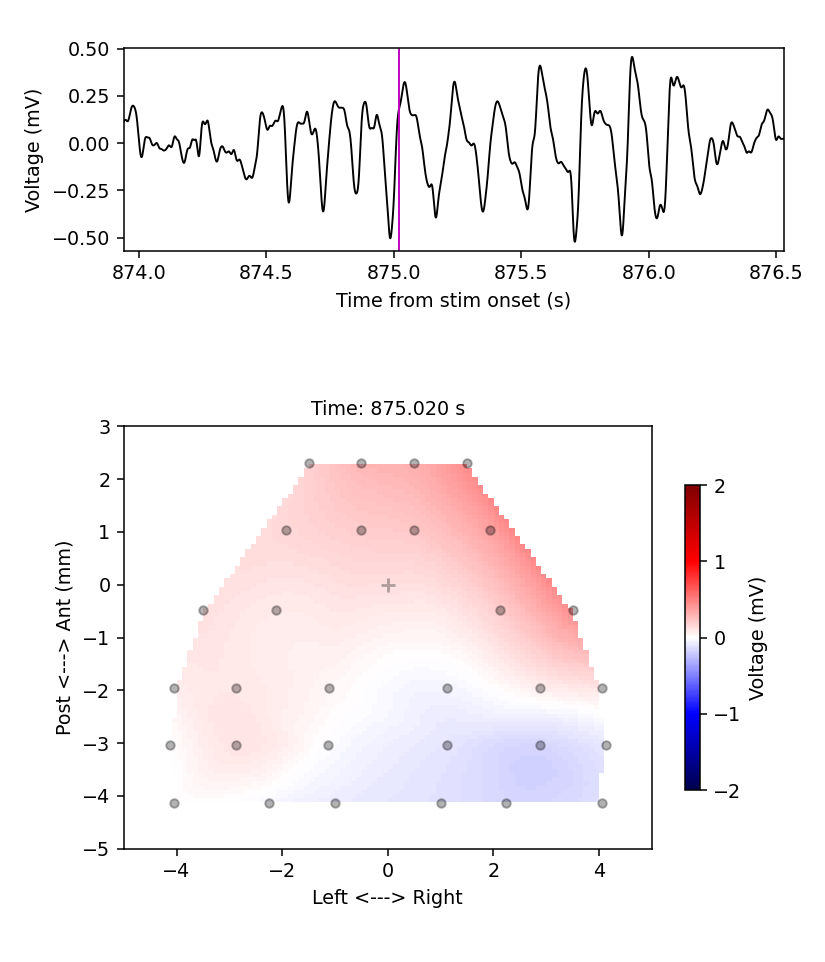

In [68]:
fig = plt.figure(figsize=(6, 7))
gs = fig.add_gridspec(ncols=1, nrows=2, top=0.95, bottom=0.02, left=0.15, right=0.95, hspace=0.2, height_ratios=[1,3])
initframe = 0

## Plot one ch with moving vertical line ##
chax = fig.add_subplot(gs[0])
chax.plot(eeg_ts[plot_inds], filt_data[plot_inds, 13], color='k', linewidth=1)
chline = chax.axvline(x=eeg_ts[frameinds[initframe]], color='m', linewidth=1)
chax.set_xlim(plot_window)
chax.set_xlabel('Time from stim onset (s)')
chax.set_ylabel('Voltage (mV)')

## Plot one ch with moving vertical line ##
hmax = fig.add_subplot(gs[1])
sptp = hmax.imshow(
    spatiotempEEG[0,:,:], cmap='seismic', vmin=-2, vmax=2,
    origin='lower', interpolation='none', extent=(ml[0], ml[-1], ap[0], ap[-1]),
)
hmax.scatter(
    EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
    c='k', alpha=0.3, marker='o', s=20
)
hmax.scatter(0, 0, marker='+', color='k', s=50, alpha=0.3)
hmax.set_aspect('equal')
hmax.set_ylabel('Post <---> Ant (mm)')
hmax.set_xlabel('Left <---> Right')

cb = fig.colorbar(sptp, ax=hmax, shrink=.5, aspect=20)
cb.set_label('Voltage (mV)')
hmax.set_title('Time: {:.3f} s'.format(eeg_ts[frameinds[initframe]]))

## animate function ##
def animate(i):
    chline.set_data([eeg_ts[frameinds[i]], eeg_ts[frameinds[i]]], [0, 1])
    sptp.set_data(spatiotempEEG[i,:,:])
    hmax.set_title('Time: {:.3f} s'.format(eeg_ts[frameinds[i]]))

## animate it ##
anim = animation.FuncAnimation(fig, animate, init_func=None, frames=frameinds.shape[0], interval=80, blit=False)

movie_name = os.path.join(plotsavedir, '{}_spatiotempEEG_{:d}-{:d}s.mp4'.format(exp_tag, int(plot_window[0]), int(plot_window[1])))
# anim.save(movie_name, writer='ffmpeg', fps=12, extra_args=['-vcodec', 'libx264'], dpi=1000, bitrate=-1)
anim.save(movie_name, writer='ffmpeg', fps=6, extra_args=['-vcodec', 'libx264'], dpi=300, bitrate=-1)

### Load stim log, if exists

In [41]:
if os.path.exists(exp.stimulus_log_file):
    stim_log = pd.read_csv(exp.stimulus_log_file)
else:
    print('No stim log for this experiment')

In [42]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,mean_speed,resting_trial,SWD,good
0,biphasic,50,0.0004,2961.90928,2961.90968,0,0.000000,True,False,True
1,biphasic,50,0.0004,2982.91487,2982.91527,0,0.000000,True,True,True
2,biphasic,50,0.0004,3001.93576,3001.93616,0,0.607456,False,False,True
3,biphasic,50,0.0004,3021.96011,3021.96051,0,0.303728,False,True,True
4,biphasic,50,0.0004,3042.75694,3042.75734,0,0.000000,True,False,True


### Plot example EEG, running, and SWD events

### Plot stim in SWD and not

In [43]:
plot_before = 0.5 # s, look at 500 ms pre-stim
plot_after = 1.0 # s, look at 1000 ms post-stim

st_type = 'biphasic'
parami = 50
compare = 'SWD'
comps = [True, False]

ERPs = {}
for compsi in comps:
    ## Get event times ##
    events = stim_log[
        (stim_log['stim_type'] == st_type) & (stim_log['parameter'] == parami) & (stim_log[compare] == compsi)].onset.values
    
    ## Get event traces ##
    event_traces, event_ts = get_evoked_traces(
        eeg_data, eeg_ts, events, plot_before, plot_after, exp.ephys_params['EEG']['sample_rate']
    )
    comavg_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]    
    ## Design Butterworth bandpass filter ##
    filtb, filta = signal.butter(3, np.array([0.1, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')

    ## Store traces ##
    ERPs[compsi] = [event_ts, signal.filtfilt(filtb, filta, comavg_traces, axis=0)]

<IPython.core.display.Javascript object>


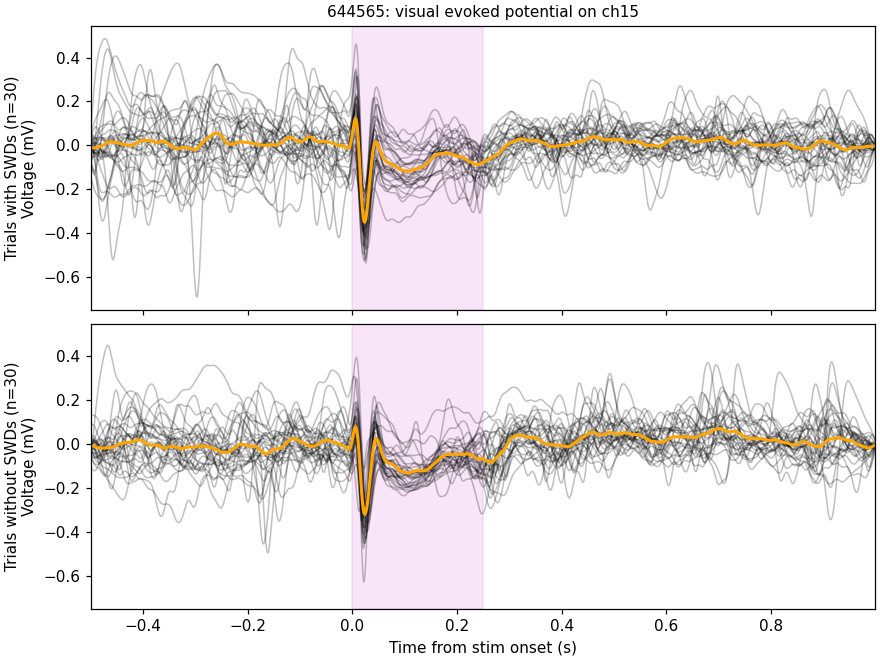

In [44]:
plot_ch = 15

fig, axs = plt.subplots(2, 1, figsize=(8,6), constrained_layout=True, sharex=True, sharey=True)
for ax, compsi in zip(axs, comps):
    timex = ERPs[compsi][0]
    EEGtraces = ERPs[compsi][1]
    ax.axvspan(0, 0.25, color='m', alpha=0.1)
    ax.plot(timex, EEGtraces[:,plot_ch,:], color='k', linewidth=1.0, alpha=0.25)
    ax.plot(timex, np.mean(EEGtraces[:,plot_ch,:], 1), color='orange', linewidth=2.0)
    
    if compsi:
        ax.set_ylabel('Trials with SWDs (n={:d})\nVoltage (mV)'.format(EEGtraces.shape[2]))
    else:
        ax.set_ylabel('Trials without SWDs (n={:d})\nVoltage (mV)'.format(EEGtraces.shape[2]))

ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time from stim onset (s)')
axs[0].set_title('{}: visual evoked potential on ch{:d}'.format(exp.mouse, plot_ch))

### SAVE ###
fig_name = '{}_VEPs_ch{:d}.png'.format(exp_tag, plot_ch)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

## Plot some window of all channels

In [38]:
plot_window = [10., 55.] # choose values in s, must match master timestamp values

plot_inds = np.nonzero((eeg_ts > plot_window[0]) & (eeg_ts < plot_window[1]))[0]

<IPython.core.display.Javascript object>


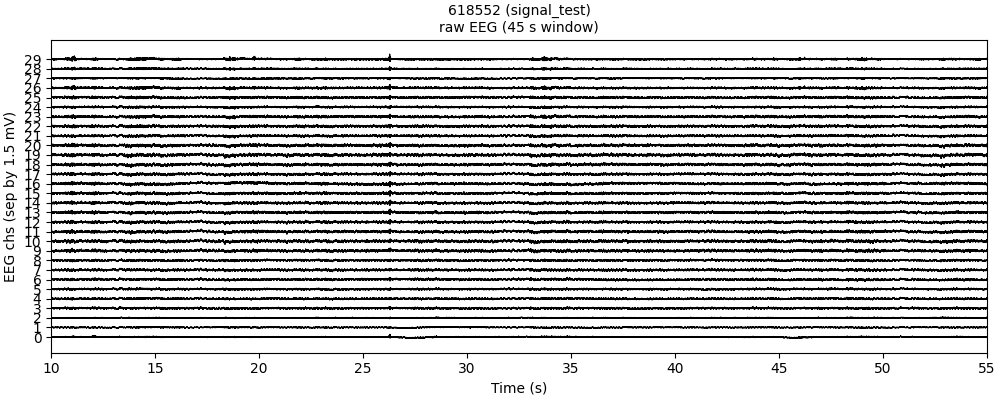

In [40]:
sep = 1.5 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
for chi in eeg_chs:
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(eeg_ts[plot_inds], eeg_data[plot_inds, chi] + sep*chi, color=trace_color, linewidth=0.8)

ax.set_xlim(plot_window)
ax.set_xlabel('Time (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(eeg_chs)
ax.set_ylabel('EEG chs (sep by {:.1f} mV)'.format(sep))
ax.set_title('{} ({})\nraw EEG ({:d} s window)'.format(exp.mouse, exp_tag, int(plot_window[1]-plot_window[0])))

### SAVE ###
fig_name = '{}_rawEEGstack_{:d}-{:d}s.png'.format(exp_tag, int(plot_window[0]), int(plot_window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Try common average reference, using all channels.

Apply a bandpass filter.

In [12]:
bpb, bpa = signal.butter(3, np.array([0.1, 20])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

<IPython.core.display.Javascript object>


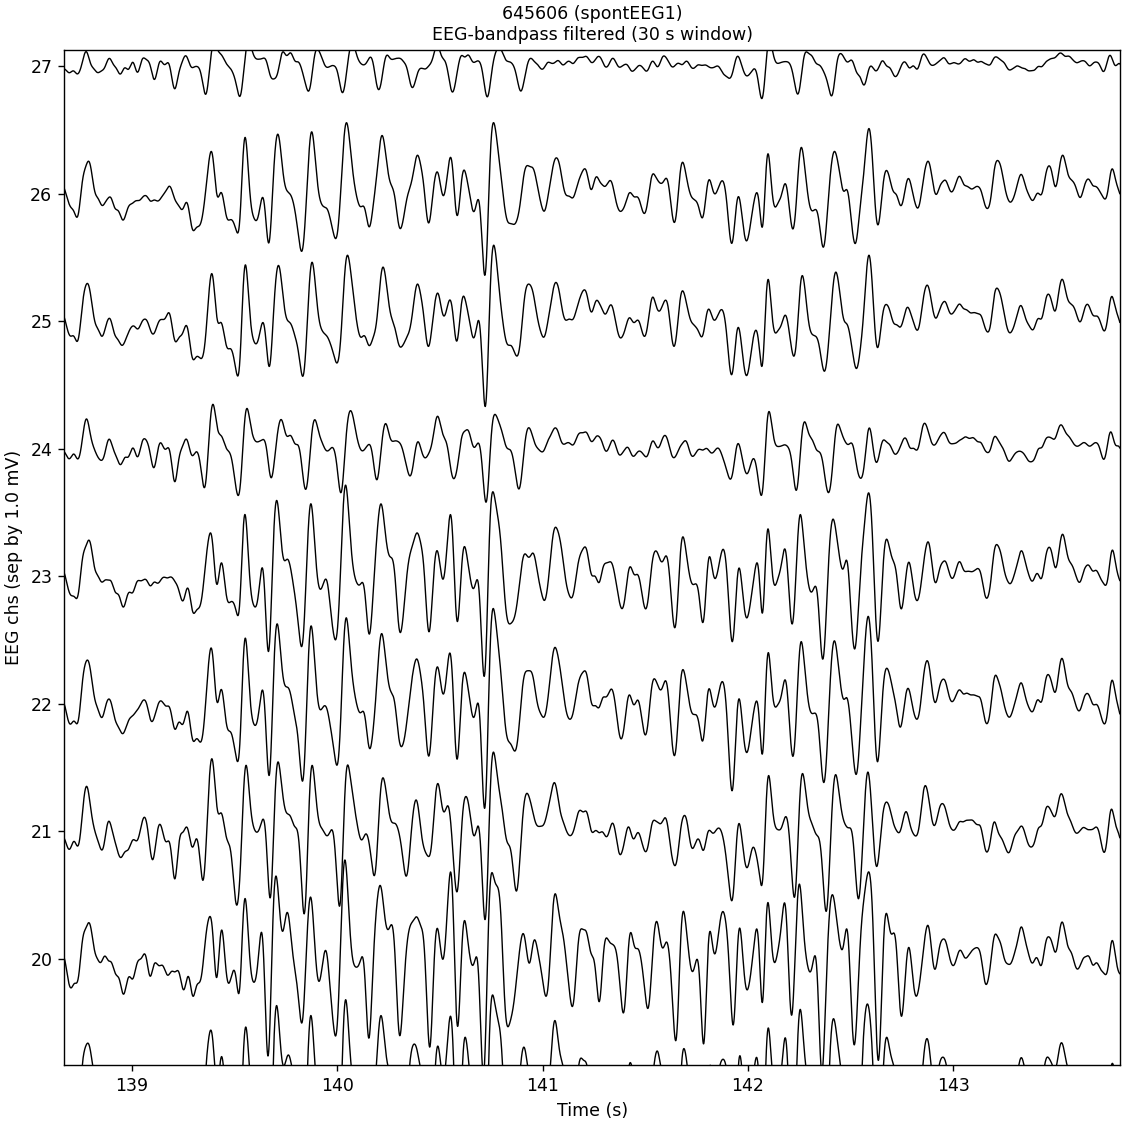

In [13]:
fig, ax = plt.subplots(figsize=(9, 9), constrained_layout=True)
for chi in eeg_chs:
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(eeg_ts[plot_inds], filt_data[plot_inds, chi] + sep*chi, color=trace_color, linewidth=0.8)

ax.set_xlim(plot_window)
ax.set_xlabel('Time (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(eeg_chs)
ax.set_ylabel('EEG chs (sep by {:.1f} mV)'.format(sep))
ax.set_title('{} ({})\nEEG-bandpass filtered ({:d} s window)'.format(exp.mouse, exp_tag, int(plot_window[1]-plot_window[0])))

### SAVE ###
fig_name = '{}_filtEEGstack_{:d}-{:d}s.png'.format(exp_tag, int(plot_window[0]), int(plot_window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Power spectrum

In [17]:
## Process the power spectrum across the whole recording ##
frex, Pxx = signal.welch(
    eeg_data, exp.ephys_params['EEG']['sample_rate'], nperseg=2 * exp.ephys_params['EEG']['sample_rate'], axis=0
)

<IPython.core.display.Javascript object>


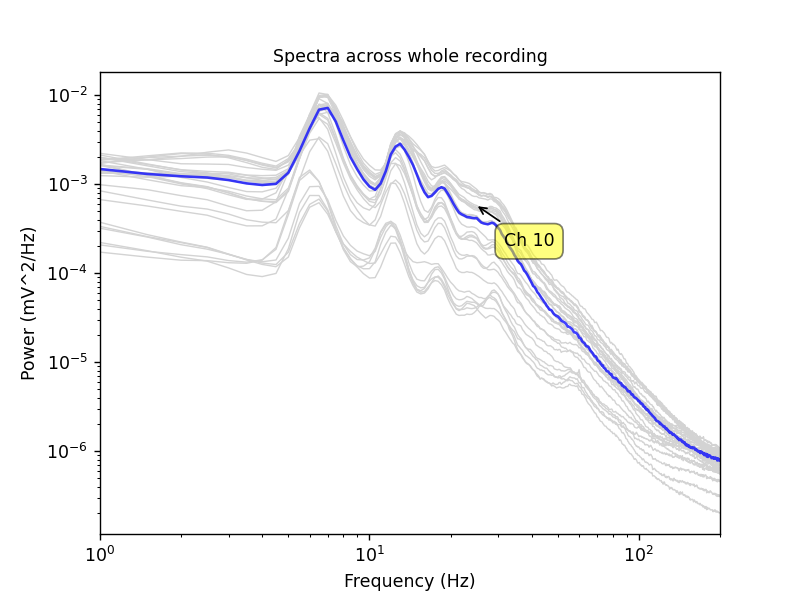

Text(0.5, 1.0, 'Spectra across whole recording')

In [18]:
frinds = frex < 200

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(ind))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([1, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across whole recording')

<IPython.core.display.Javascript object>


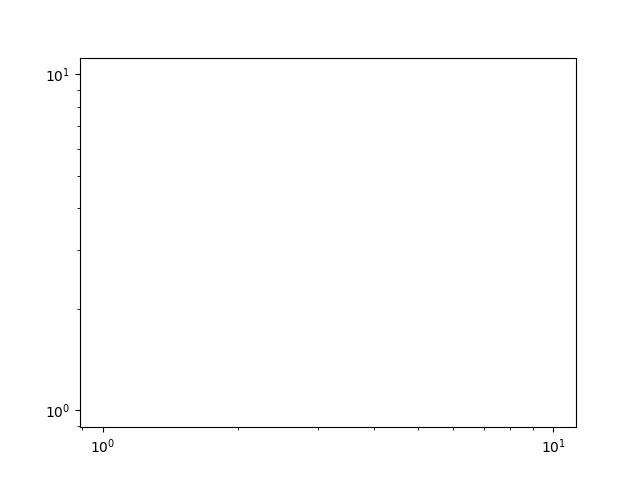

ValueError: array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.37254902e-01, 9.84002783e-02, 9.98785992e-01, 1.00000000e+00],
       [3.66666667e-01, 2.07911691e-01, 9.94521895e-01, 1.00000000e+00],
       [2.96078431e-01, 3.14869589e-01, 9.87201840e-01, 1.00000000e+00],
       [2.25490196e-01, 4.17960345e-01, 9.76848318e-01, 1.00000000e+00],
       [1.54901961e-01, 5.15917826e-01, 9.63493144e-01, 1.00000000e+00],
       [9.21568627e-02, 5.97707459e-01, 9.49134944e-01, 1.00000000e+00],
       [2.15686275e-02, 6.82748855e-01, 9.30229309e-01, 1.00000000e+00],
       [4.90196078e-02, 7.59404917e-01, 9.08465272e-01, 1.00000000e+00],
       [1.19607843e-01, 8.26734175e-01, 8.83909710e-01, 1.00000000e+00],
       [1.90196078e-01, 8.83909710e-01, 8.56638078e-01, 1.00000000e+00],
       [2.60784314e-01, 9.30229309e-01, 8.26734175e-01, 1.00000000e+00],
       [3.23529412e-01, 9.61825643e-01, 7.98017227e-01, 1.00000000e+00],
       [3.94117647e-01, 9.86200747e-01, 7.63398283e-01, 1.00000000e+00],
       [4.64705882e-01, 9.98463604e-01, 7.26433574e-01, 1.00000000e+00],
       [5.35294118e-01, 9.98463604e-01, 6.87236686e-01, 1.00000000e+00],
       [6.05882353e-01, 9.86200747e-01, 6.45928062e-01, 1.00000000e+00],
       [6.76470588e-01, 9.61825643e-01, 6.02634636e-01, 1.00000000e+00],
       [7.39215686e-01, 9.30229309e-01, 5.62592752e-01, 1.00000000e+00],
       [8.09803922e-01, 8.83909710e-01, 5.15917826e-01, 1.00000000e+00],
       [8.80392157e-01, 8.26734175e-01, 4.67657593e-01, 1.00000000e+00],
       [9.50980392e-01, 7.59404917e-01, 4.17960345e-01, 1.00000000e+00],
       [1.00000000e+00, 6.82748855e-01, 3.66978792e-01, 1.00000000e+00],
       [1.00000000e+00, 5.97707459e-01, 3.14869589e-01, 1.00000000e+00],
       [1.00000000e+00, 5.15917826e-01, 2.67733003e-01, 1.00000000e+00],
       [1.00000000e+00, 4.17960345e-01, 2.13933083e-01, 1.00000000e+00],
       [1.00000000e+00, 3.14869589e-01, 1.59475791e-01, 1.00000000e+00],
       [1.00000000e+00, 2.07911691e-01, 1.04528463e-01, 1.00000000e+00],
       [1.00000000e+00, 9.84002783e-02, 4.92599411e-02, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]]) is not a valid value for color

In [69]:
frinds = frex < 200

fig, ax = plt.subplots()

colors = plt.cm.rainbow(np.linspace(0, 1, Pxx.shape[1]))
spectra = ax.loglog(frex[frinds], Pxx[frinds,:], c=colors, linewidth=0.8)

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='k', linewidth=1.5, alpha=0.75)
ax.set_xlim([1, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across whole recording')

### Plotting

Plot the visual evoked response across all electrodes. This plots all electrodes in the array layout, with bad chs in red. You can choose to plot:
- 'raw': raw signals, averaged across all trials
- 'filtered': bandpass filtered signals, averaged across all trials
- 'common_averaged': raw signals that have been common average referenced to all good chs, then filtered and averaged across all trials

<IPython.core.display.Javascript object>


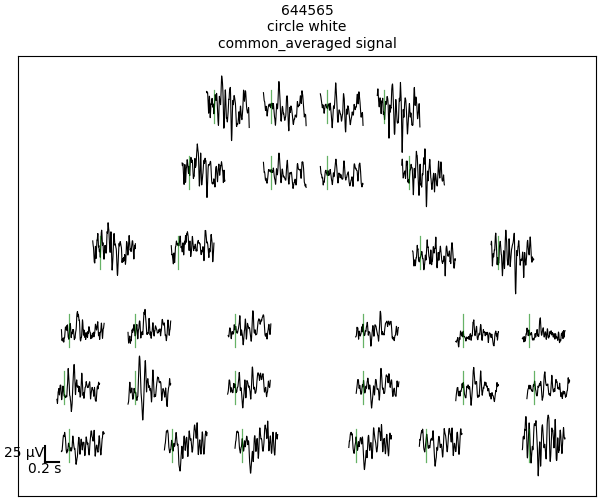

In [35]:
plot_stim_type = 'circle'
plot_stim_param = 'white'
plot_sweep = 0
plot_traces = 'common_averaged' # choose: 'raw', 'filtered', or 'common_averaged'

# if remove_bad_trials:
#     tag = 'good'
# else:
#     tag = 'all'

prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 80 # changes vertical distance between traces, usually 100 for VEPs

timex = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][0]
plottraces = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][1]
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(
        timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        trace_color,
        linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
#     ax.plot([0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
#              0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
#             [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
#              25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
#             color='r', linewidth=0.9, alpha=0.6)
    if chi == 0:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.95
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_arrayplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)

## UNCOMMENT TO SAVE THE FIGURE ##
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

In [35]:
snr_dur = 0.2

binds = np.squeeze(np.argwhere((timex >= -snr_dur) & (timex < 0)))
rinds = np.squeeze(np.argwhere((timex > 0) & (timex <= snr_dur)))

base_power = np.mean(np.square(plottraces[binds, :]), axis=0)
resp_power = np.mean(np.square(plottraces[rinds, :]), axis=0)
snrs = np.sqrt(resp_power / base_power)
print(snrs)
print(np.mean(snrs))

[1.95017782 5.24227399 1.42381525 5.16199239 4.37454255 4.24241459
 3.51264115 1.21593842 3.83742894 1.8955301  1.89893429 1.8067833
 0.81062434 1.23805703 0.87227716 0.9842449  2.95423934 1.29269561
 4.07347692 2.26632062 1.86270402 1.81373157 0.51786046 0.52933825
 2.45093971 0.39612949 0.46196817 2.47845535 0.79152483 0.52708515]
2.0961381906796692


#### Same plot above, but as a butterfly plot

<IPython.core.display.Javascript object>


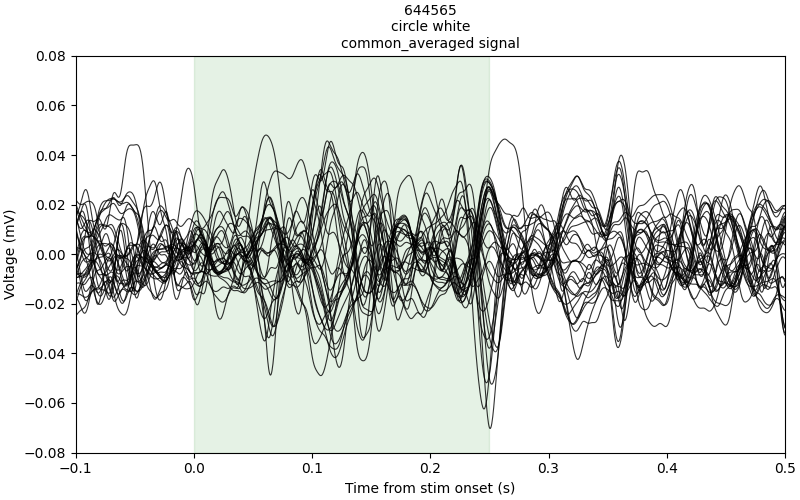

In [36]:
ylimit = 0.08 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
for chi in GOOD_CHS:
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000, color='k', linewidth=0.8, alpha=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_butterflyplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

#### Same plot, but with electrodes vertically stacked

<IPython.core.display.Javascript object>


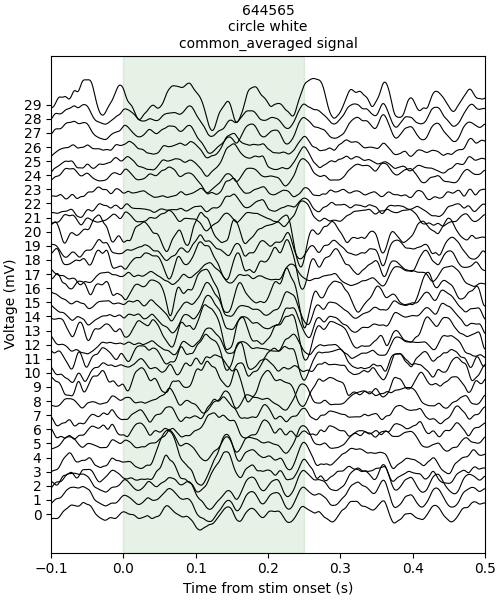

In [37]:
sep = 0.025 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(5, 6), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000 + sep*chi, color=trace_color, linewidth=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_xlabel('Time from stim onset (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(range(len(exp.EEG_channel_coordinates)))
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_stackedplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

### Plot whole traces

<IPython.core.display.Javascript object>


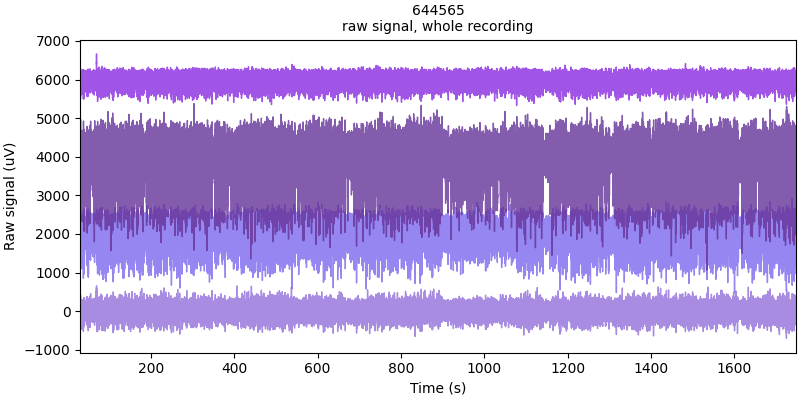

In [30]:
plot_chs = [0,3,13,27]
chcolors = ['mediumpurple','mediumslateblue','rebeccapurple','blueviolet','darkorchid','darkviolet']
# chcolors = ['crimson','blue','gold','green','darkviolet','deeppink']

offset = 2000 # 500
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

for i, chi in enumerate(plot_chs):
    ax.plot(eeg_ts, eeg_data[:,chi] + i*offset, color=chcolors[i], linewidth=1, alpha=0.8, label=('Ch {:d}'.format(chi)))

ax.set_xlim((eeg_ts[0], eeg_ts[-1]))
# ax.set_ylim((-500, 2200))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw signal (uV)')
ax.set_title('{}\nraw signal, whole recording'.format(exp.mouse))
# ax.legend()

### SAVE: this will save the figure in the recording1 folder ###
fig_name = 'whole_raw_signals.png'
fig.savefig(os.path.join(recfolder, fig_name), transparent=True)